## Librerie

In [125]:
from langchain.vectorstores import Chroma    # vectordb
from langchain_community.llms import Ollama  # llm
from langchain_community.embeddings import HuggingFaceEmbeddings # embedder
from langchain.chains.combine_documents import create_stuff_documents_chain # chain 
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.docstore.document import Document as LangchainDocument
from tqdm.notebook import tqdm

## others
import pandas as pd
import numpy as np
import pprint
from datasets import load_dataset
import matplotlib.pyplot as plt

## Load documents

In [2]:
train_ds, val_ds = load_dataset("squad", split=['train', 'validation'])

In [3]:
train_ds

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

Create a dataframe of the train_ds

In [43]:
train_df = train_ds.to_pandas()
train_df = train_df.loc[:, train_df.columns.delete([0,1])] # remove question id and title

In [44]:
train_df.loc[:, 'context_id'] = train_df.context.factorize()[0] 
train_df.loc[:, 'question_id'] = train_df.question.factorize()[0] 

In [48]:
# number of q
train_df.question_id.max()+1

87355

In [49]:
# number of passages
train_df.context_id.max()+1

18891

In [67]:
# question per documents
question_per_doc = train_df.loc[:, ['context_id', 'question_id']].groupby('context_id').size().to_dict()

In [69]:
train_df.loc[:, 'q_per_doc'] = train_df.context_id.map(question_per_doc)

In [70]:
train_df.head()

,context,question,answers,context_id,question_id,q_per_doc
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ...",0,0,5
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe...",0,1,5
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'...",0,2,5
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...,0,3,5
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...,0,4,5


In [85]:
# statistic of squad for unique document
train_df.drop_duplicates(subset = 'context_id').q_per_doc.describe()

count    18891.000000
mean         4.637076
std          1.682278
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max         25.000000
Name: q_per_doc, dtype: float64

Text(0.5, 0, 'document id')

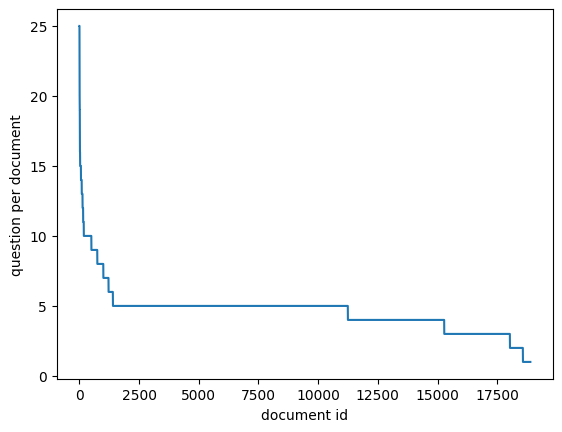

In [99]:
plt.plot(train_df.drop_duplicates(subset = 'context_id').sort_values(by = 'q_per_doc', ascending = False).q_per_doc.values)
plt.ylabel('question per document')
plt.xlabel('document id')

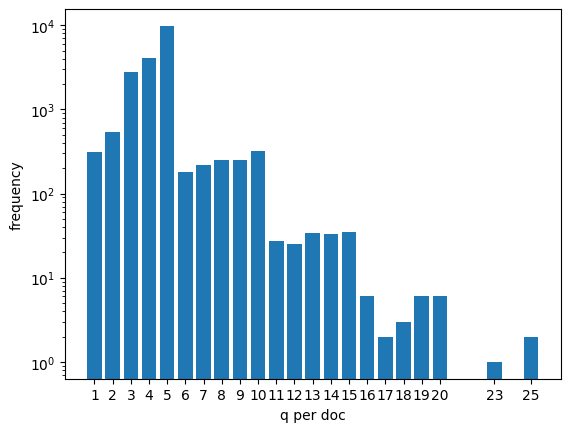

In [118]:
labels, counts = np.unique(train_df.drop_duplicates(subset = 'context_id').q_per_doc, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.yscale('log', base = 10)
plt.xlabel('q per doc')
plt.ylabel('frequency')
plt.show()

aumentiamo query:
- rephrase it
- unify qEa

- quali? power law

In [183]:
def retrieve_gt(q_id, dataset = train_df):
    context = dataset.loc[dataset.question_id == q_id, 'context'].values[0]
    answer = dataset.loc[dataset.question_id == q_id, 'answers'].values[0]['text'][0]
    return context, answer

In [184]:
context, answer = retrieve_gt(0)

## Build corpus database

In [123]:
unique_df = train_df.drop_duplicates(subset = 'context_id').copy()
unique_df.sample(10)

,context,question,answers,context_id,question_id,q_per_doc
83088,The Ptolemaic Kingdom was a powerful Hellenist...,What were the reaches of the Ptolemaic Kingdom?,"{'text': ['Syria in the east, to Cyrene to the...",17972,82875,4
57471,"After World War II, two new competing formats ...",What two formats replaced the 78?,{'text': ['33 1⁄3 rpm (often just referred to ...,12378,57312,5
73050,Airborne Interception radar (AI) was unreliabl...,The bombers used what out of desperation?,"{'text': ['airborne search lights'], 'answer_s...",15851,72872,4
80871,"Japan saw the release of the Satellaview, a mo...",What modem was available for the Japanese SNES?,"{'text': ['Satellaview'], 'answer_start': [29]}",17475,80669,5
25329,Many components of the immune system are typic...,The structure of immune system components can ...,"{'text': ['typically cellular in nature'], 'an...",5690,25250,4
39521,Undergraduate tuition for the 2012/13 school y...,What was the total undergrad tuition for the 2...,"{'text': ['$61,240'], 'answer_start': [54]}",8543,39402,5
13537,"In the 1950s, Universal-International resumed ...",Who did many of Universal-International's Arab...,"{'text': ['Tony Curtis'], 'answer_start': [98]}",2924,13479,5
6628,"Besides emptiness, Mahayana schools often plac...",What does tathagatagarbha mean?,"{'text': ['Buddha-nature'], 'answer_start': [1...",1134,6593,5
9870,"While the terms ""institute of technology"" and ...","What word means the same thing as ""institute o...","{'text': ['polytechnic'], 'answer_start': [47]}",1799,9820,1
18953,"Elsewhere, remnants of the medieval water supp...",In what year was the friars' water supply syst...,"{'text': ['1290'], 'answer_start': [118]}",4248,18888,5


In [141]:
# create knowledge base 
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["context"], metadata={'context_id': doc['context_id']}) for doc in tqdm(unique_df.to_dict('records'))
]

  0%|          | 0/18891 [00:00<?, ?it/s]

In [142]:
RAW_KNOWLEDGE_BASE[0]

Document(page_content='Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', metadata={'context_id': 0})

Splits documents

In [143]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, 
                                               chunk_overlap=50,
                                               add_start_index=True)

texts = text_splitter.split_documents(RAW_KNOWLEDGE_BASE)

In [144]:
len(texts)

22041

Initialize ChromaDB

In [135]:
EMBEDDING_MODEL_NAME = 'intfloat/e5-large-v2'

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

In [146]:
load_from_disk = True 
chroma_db_path = r'C:/Users/giuli/Documents/ragcache/chroma_db/squad_v3_context_only'

if not load_from_disk:
    KNOWLEDGE_VECTOR_DATABASE = Chroma.from_documents(texts, embedding_model, persist_directory=chroma_db_path)  
else:
    KNOWLEDGE_VECTOR_DATABASE = Chroma(persist_directory=chroma_db_path, embedding_function=embedding_model)

## Retriever function

In [137]:
## reranker 
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

In [138]:
def retriever(
    question,
    knowledge_index,
    num_retrieved_docs = 30,
    reranker = None,
    num_docs_final = 5
):
    #print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text
 
    # Optionally rerank results
    if reranker:
        #print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]
    return relevant_docs

Pipeline

In [149]:
q_id, question = train_df.loc[0, ['question_id', 'question']].values
q_id, question

(0, 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?')

In [150]:
%%time
context = retriever(question,
                    KNOWLEDGE_VECTOR_DATABASE,
                    reranker=RERANKER)

## pass context to llm
## asnwer


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]

CPU times: total: 93.8 ms
Wall time: 4.55 s


In [140]:
context

['Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'The presence of the Virgin Mary under the cross[Jn. 19:26-27] has in itself been the subject of Marian art, and well known Catholic symbolism such as the Miraculous Medal and Pope John Paul II\'s Coat of Arms bearing a Marian Cross. And a number of Marian devotions also involve the presence of th

In [152]:
train_df.loc[train_df.question_id == q_id, 'context'].values[0]

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

## Caching 

In [153]:
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np

# initizile caching retrieval
model = CrossEncoder(r"C:/Users/giuli/Documents/ragcache/models/training_quora-2024-03-05_14-36-08")

In [243]:
## fantasy cache
class Cache:
    def __init__(self, max_size):
        self.cache = {}  # actual cache (query, context)
        self.queries = []  # easy query retrieval
        self.LFU = {}  # for caching managing
        self.q_index = 0
        self.max_size = max_size
        
    def add_to_cache(self, query, context):
        # add if space available
        if self.len() < self.max_size:  
            # append new query
            self.queries.append(query)
            if isinstance(context, list) and len(context)>1:
                self.contexts.extend(context)
            else:
                self.contexts.append(context)
            self.cache[self.q_index] = context
            self.LFU[self.q_index] = 0
            self.q_index += 1 
        # if full -> free space 
        else:
            # decide what to free
            LFU_key = min(self.LFU, key=self.LFU.get)
            # replace
            self.queries[LFU_key] = query
            self.cache[LFU_key] = context

    def delete_cache(self):
        self.cache = {}  
        self.queries = []  
        self.LFU = {}  
        self.q_index = 0
        
    def __getitem__(self,key):
        return self.cache[key]
        
    def len(self):
        return len(self.queries)

In [253]:
## fantasy cache
class Cache2:
    def __init__(self, max_size):
        self.cache = {}  # actual cache (query, context)
        self.context = []  # easy query retrieval
        self.LFU = {}  # for caching managing
        self.c_index = 0
        self.max_size = max_size
        
    def add_to_cache(self, question, context):
        # add if space available add
        for doc in context:
            # if not duplicate
            if doc not in self.context:
                if self.len() < self.max_size: 
                    # append new context
                    self.context.append(doc)
                    self.cache[self.c_index] = doc
                    self.LFU[self.c_index] = 0
                    self.c_index += 1   
                # if full -> free space 
                else:
                    # decide what to free
                    LFU_key = min(self.LFU, key=self.LFU.get)
                    # replace
                    self.context[LFU_key] = doc
                    self.cache[LFU_key] = doc

    def delete_cache(self):
        self.cache = {}  
        self.queries = []  
        self.LFU = {}  
        self.q_index = 0
        
    def __getitem__(self,key):
        return self.cache[key]
        
    def len(self):
        return len(self.context)

In [236]:
## retrieve all the queries
QUESTIONS = train_df.loc[:, ['question_id', 'question']].to_dict('records')
print('total n di query: ', len(QUESTIONS))

total n di query:  87599


In [263]:
def populate_cache(QUESTIONS, cache,
                   element_in_cache = 30, 
                   specific_q = None,
                   corpus_db = KNOWLEDGE_VECTOR_DATABASE,
                   reranker = RERANKER):
    
    ## sample X question and insert them in cache
    idxs = np.random.choice(range(len(QUESTIONS)), element_in_cache, replace=False)
    sample_questions = [QUESTIONS[idx]['question'] for idx in idxs]
    if specific_q:
        for q_id in specific_q:
            sample_questions.append(QUESTIONS[q_id]['question'])  
        
    ## simulate some passages of query
    for q in tqdm(sample_questions):
        context = retriever(q,
                            corpus_db,
                            reranker=reranker)
        ## add to cache
        cache.add_to_cache(q, context)

In [272]:
## initialize cache
cache = Cache2(max_size = 40)

In [273]:
populate_cache(QUESTIONS, cache, element_in_cache = 5, specific_q = [0,1])

  0%|          | 0/7 [00:00<?, ?it/s]



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


In [274]:
cache.context

['The Nazis, led by Adolf Hitler, attempted to unite all the people they claimed were "Germans" (Volksdeutsche) into one realm, including ethnic Germans in eastern Europe, many of whom had emigrated more than one hundred fifty years before and developed separate cultures in their new lands. This idea was initially welcomed by many ethnic Germans in Sudetenland, Austria, Poland, Danzig and western Lithuania, particularly the Germans from Klaipeda (Memel). The Swiss resisted the idea. They had viewed themselves as a distinctly separate nation since the Peace of Westphalia of 1648.',
 "Pan-Germanism's origins began in the early 19th century following the Napoleonic Wars. The wars launched a new movement that was born in France itself during the French Revolution. Nationalism during the 19th century threatened the old aristocratic regimes. Many ethnic groups of Central and Eastern Europe had been divided for centuries, ruled over by the old Monarchies of the Romanovs and the Habsburgs. Ger

comparison retrieval document in cache vs (query, cache)


evaluation fatta in modo x


In [163]:
%%time
new_query = QUESTIONS[1]['question']
similar_query = model.rank(new_query, cache.queries,
                           top_k=10,
                           return_documents=False) # 300ms vs 4.28s
# initialize new_context
new_context = set()
for q in similar_query:
    corpus_id = q['corpus_id']
    new_context.update(cache[corpus_id])

# rereank new context and decide if its enough
relevant_docs = RERANKER.rerank(new_query, list(new_context), k = 5)
scores = [doc["score"] for doc in relevant_docs]
if any(x>15 for x in scores):
    print('daje stava in cache')
    relevant_docs = [doc["content"] for doc in relevant_docs]
    # update
    for q in similar_query: 
        cache.LFU[q['corpus_id']] += 1
else:
    # retrieve...
    print('need retrieve')


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]

need retrieve
CPU times: total: 109 ms
Wall time: 139 ms


In [165]:
new_query, retrieve_gt(1)

('What is in front of the Notre Dame Main Building?',
 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.')

In [166]:
[doc["content"] for doc in relevant_docs]  # infatti non ci sta

['The University of Kansas (KU) is a public research university and the largest in the U.S. state of Kansas. KU branch campuses are located in the towns of Lawrence, Wichita, Overland Park, Salina, and Kansas City, Kansas, with the main campus located in Lawrence on Mount Oread, the highest location in Lawrence. Founded March 21, 1865, the university was opened in 1866, under a charter granted by the Kansas State Legislature in 1864 following enabling legislation passed in 1863 under the Kansas State Constitution, adopted two years after the 1861 admission of the former Kansas Territory as the 34th state into the Union following a very famous bloody internal civil war known as "Bleeding Kansas" during the 1850s.',
 'The first union was built on campus in 1926 as a campus community center. The unions are still the "living rooms" of campus today and include three locations – the Kansas Union and Burge Union at the Lawrence Campus and Jayhawk Central at the Edwards Campus. The KU Memorial

## all in one

1. Dove mettere cache?
   1. dopo retriever o dopo reranker???
  
      
2. retriver score da capire threshold

 
4. better model per similarity query:
   1. q vs q ?
   2. q vs doc?
   3. bi encoder vs cross?
   4. esiste conditional contrastive learning, esiste una cosa simile per Binary Cross entropy?


5. bisogno di ulteriori sistemi di caching oltre LFU?

   
Domande focus ricerca:
1. trade off performance decrease vs efficency in time


Future implementazioni:
1. aggiungere cache di risposta llm
   1. secondo modello per check se due q's possono essere risposte da stessa risposta

In [224]:
def retrieve_and_cache(
    question,
    knowledge_index,
    cache,
    num_retrieved_docs = 30,
    reranker = None,
    num_docs_final = 5
):
    #print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text
    
    # Optionally rerank results
    if reranker:
        #print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # caching relevant docs
    cache.add_to_cache(question, relevant_docs)
    
    return relevant_docs

In [225]:
def caching_retriever(
    question,
    knowledge_index,
    cache, 
    num_retrieved_docs = 30,
    reranker = None,
    num_docs_final = 5
):

    # look in cache if not empty
    if cache.queries:
        # return similar (query, context)
        similar_query = model.rank(question, cache.queries,
                                   top_k=10, # return top10 question
                                   return_documents=False)  
        # initialize relevant_docs and populate with caching docs corresponding to the sim queries
        relevant_docs = set()
        for q in similar_query:
            relevant_docs.update(cache[q['corpus_id']])
        # rereank relevant_docs
        relevant_docs = reranker.rerank(question, list(relevant_docs), k = num_docs_final)
        scores = [doc["score"] for doc in relevant_docs]
        # if they are true relevant keep it else retrieve from full corpus
        if any(x>15 for x in scores):
            relevant_docs = [doc["content"] for doc in relevant_docs]
            # update
            for q in similar_query: 
                cache.LFU[q['corpus_id']] += 1
            return relevant_docs
        else:
            # retrieve...
            return retrieve_and_cache(question,
                      knowledge_index,
                      cache, 
                      num_retrieved_docs = num_retrieved_docs,
                      reranker = reranker,
                      num_docs_final = num_docs_final
                     )

    # if cache is empty than retrieve from full corpus
    relevant_docs = retrieve_and_cache(question,
                      knowledge_index,
                      cache, 
                      num_retrieved_docs = num_retrieved_docs,
                      reranker = reranker,
                      num_docs_final = num_docs_final
                     )
    
    return relevant_docs

In [300]:
def caching_retriever_on_docs(
    question,
    knowledge_index,
    cache, 
    num_retrieved_docs = 30,
    reranker = None,
    num_docs_final = 5
):

    # look in cache if not empty
    if cache.context:
        # rereank relevant_docs
        relevant_docs = reranker.rerank(question, list(set(cache.context)), k = num_docs_final)
        scores = [doc["score"] for doc in relevant_docs]
        # if they are true relevant keep it else retrieve from full corpus
        if any(x>15 for x in scores):
            # update
            for doc in relevant_docs: 
                cache.LFU[doc['result_index']] += 1
            relevant_docs = [doc["content"] for doc in relevant_docs]
            return relevant_docs
        else:
            # retrieve...
            return retrieve_and_cache(question,
                      knowledge_index,
                      cache, 
                      num_retrieved_docs = num_retrieved_docs,
                      reranker = reranker,
                      num_docs_final = num_docs_final
                     )

    # if cache is empty than retrieve from full corpus
    relevant_docs = retrieve_and_cache(question,
                      knowledge_index,
                      cache, 
                      num_retrieved_docs = num_retrieved_docs,
                      reranker = reranker,
                      num_docs_final = num_docs_final
                     )
    
    return relevant_docs

In [226]:
import re
def cache_it(relevant_doc, retrieved_doc):
    '''check if chunk doc is in full doc'''
    for doc in retrieved_doc: 
        if re.search(re.escape(doc), relevant_doc):
            return 1
    return 0

In [227]:
def llm_metric(answer, prediction):
    prediction = normalize_text(prediction)
    answer = normalize_text(answer)
    score = 0
    if re.search(re.escape(prediction), answer):
        score = 1
    elif score == 0 and re.search(re.escape(answer), prediction):
        score = 1
    return score

In [228]:
# these functions are heavily influenced by the HF squad_metrics.py script
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)


## Initialize LLM

In [229]:
llm = Ollama(model="llama2:7b-chat", temperature = 0)

In [230]:
# create chain for documents
template = """Answer the following question based only on the provided context:

<context>
{context}
</context>

Respond with a response in the format requested by the user. 
Do not acknowledge my request with "sure" or in any other way besides going straight to the answer.
Only give a coincise answer. 
Question: {input}
"""

prompt = ChatPromptTemplate.from_template(template)
document_chain = create_stuff_documents_chain(llm, prompt)

In [174]:
q = QUESTIONS[0]['question']

context = retriever(q,
                    KNOWLEDGE_VECTOR_DATABASE,
                    reranker=RERANKER) 

prediction = document_chain.invoke({
    "input": q,
    "context": [Document(page_content=txt) for txt in context]
})


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


In [186]:
context, answer = retrieve_gt(0)

q, prediction, answer

('To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 ' Saint Bernadette Soubirous.',
 'Saint Bernadette Soubirous')

In [187]:
llm_metric(answer, prediction)

1

## Experiment

Interessante capire quando:
- 5 documenti risponoono a 39840 query e gli altri a un paio
- ordine in cui arrivano: tutte iid , prima molte per lo stesso doc e poi random, etc


In [202]:
## retrieve all the queries
QUESTIONS = train_df.loc[:, ['question_id', 'question']].to_dict('records')
print('total n di query: ', len(QUESTIONS))

total n di query:  87599


In [288]:
QUESTIONS[:5]

[{'question_id': 0,
  'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'},
 {'question_id': 1,
  'question': 'What is in front of the Notre Dame Main Building?'},
 {'question_id': 2,
  'question': 'The Basilica of the Sacred heart at Notre Dame is beside to which structure?'},
 {'question_id': 3, 'question': 'What is the Grotto at Notre Dame?'},
 {'question_id': 4,
  'question': 'What sits on top of the Main Building at Notre Dame?'}]

In [213]:
from random import shuffle
QUESTION_sample = QUESTIONS[:300]
shuffle(QUESTION_sample)

In [214]:
len(QUESTION_sample)

300

In [303]:
import pickle
save = False
if save:
    with open('QUESTION_sample.pickle', 'wb') as handle:
        pickle.dump(QUESTION_sample, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('QUESTION_sample.pickle', 'rb') as handle:
        QUESTION_sample = pickle.load(handle)

In [216]:
%%time  

### --- NO CACHING 
retrieval_acc = 0
llm_acc, f1_score = 0, 0
total_q = len(QUESTION_sample)

all_pairs_llm = []
for q in tqdm(QUESTION_sample):
    q_id, question = q['question_id'], q['question']
    ##### RETRIEVER ########
    context = retriever(question,
                    KNOWLEDGE_VECTOR_DATABASE,
                    reranker=RERANKER)  
    relevant_doc, answer = retrieve_gt(q_id)
     
    # metric
    retrieval_acc += cache_it(relevant_doc, context)/total_q

    ### LLM #####
    prediction = document_chain.invoke({
    "input": question,
    "context": [Document(page_content=txt) for txt in context]
        })

    # metric
    llm_acc += llm_metric(answer, prediction)/total_q
    f1_score += compute_f1(prediction, answer)/total_q
    all_pairs_llm.append( (answer, prediction) )

  0%|          | 0/300 [00:00<?, ?it/s]



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.77it/s]


100%|█████████████████

CPU times: total: 24.1 s
Wall time: 35min 17s


In [217]:
llm_acc, f1_score, retrieval_acc

(0.719999999999999, 0.39531103206660995, 0.8899999999999972)

In [231]:
%%time

## ----- cache 
retrieval_acc = 0
llm_acc, f1_score = 0,0
total_q = len(QUESTION_sample)

# initizialize cache
cache = Cache(30)  
for q in tqdm(QUESTION_sample):
    q_id, question = q['question_id'], q['question']
    context = caching_retriever(question,
                                KNOWLEDGE_VECTOR_DATABASE,
                                reranker=RERANKER,
                                cache = cache)
    relevant_doc, answer = retrieve_gt(q_id)
    
    # metric
    retrieval_acc += cache_it(relevant_doc, context)/total_q

    ### LLM #####
    prediction = document_chain.invoke({
    "input": question,
    "context": [Document(page_content=txt) for txt in context]
        })

    # metric
    llm_acc += llm_metric(answer, prediction)/total_q
    f1_score += compute_f1(prediction, answer)/total_q

  0%|          | 0/300 [00:00<?, ?it/s]



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.84it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.65it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.90it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.44it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.78it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


100%|█████████████████

CPU times: total: 33.6 s
Wall time: 17min 26s


In [232]:
llm_acc, f1_score, retrieval_acc

(0.4233333333333341, 0.3485867265412748, 0.4400000000000009)

Downside: invece di 1 query (piccolo), storing di 5 doc grandi! 

Upside: 150doc sono tutte diversi! 30 query possono riferirsi agli stessi doc!

In [304]:
%%time

## ----- cache 
retrieval_acc = 0
llm_acc, f1_score = 0,0
total_q = len(QUESTION_sample)

# initizialize cache
cache = Cache2(150)  
for q in tqdm(QUESTION_sample):
    q_id, question = q['question_id'], q['question']
    context = caching_retriever_on_docs(question,
                                KNOWLEDGE_VECTOR_DATABASE,
                                reranker=RERANKER,
                                cache = cache)
    relevant_doc, answer = retrieve_gt(q_id)
    
    # metric
    retrieval_acc += cache_it(relevant_doc, context)/total_q

    ### LLM #####
    prediction = document_chain.invoke({
    "input": question,
    "context": [Document(page_content=txt) for txt in context]
        })

    # metric
    llm_acc += llm_metric(answer, prediction)/total_q
    f1_score += compute_f1(prediction, answer)/total_q

  0%|          | 0/300 [00:00<?, ?it/s]



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.90it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.41it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


100%|█████████████████

CPU times: total: 42.1 s
Wall time: 16min 35s


In [305]:
llm_acc, f1_score, retrieval_acc

(0.5300000000000009, 0.4141274778390987, 0.5566666666666673)

In [306]:
%%time

## ----- cache 
retrieval_acc = 0
llm_acc, f1_score = 0,0
total_q = len(QUESTION_sample)

# initizialize cache
cache = Cache2(30)  
for q in tqdm(QUESTION_sample):
    q_id, question = q['question_id'], q['question']
    context = caching_retriever_on_docs(question,
                                KNOWLEDGE_VECTOR_DATABASE,
                                reranker=RERANKER,
                                cache = cache)
    relevant_doc, answer = retrieve_gt(q_id)
    
    # metric
    retrieval_acc += cache_it(relevant_doc, context)/total_q

    ### LLM #####
    prediction = document_chain.invoke({
    "input": question,
    "context": [Document(page_content=txt) for txt in context]
        })

    # metric
    llm_acc += llm_metric(answer, prediction)/total_q
    f1_score += compute_f1(prediction, answer)/total_q

  0%|          | 0/300 [00:00<?, ?it/s]



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.84it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.61it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s]


100%|█████████████████

CPU times: total: 18.4 s
Wall time: 17min 14s


In [307]:
llm_acc, f1_score, retrieval_acc

(0.4400000000000009, 0.34054187644205597, 0.4466666666666676)